In [1]:
import numpy as np
import pandas as pd 
import copy

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow import keras

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import matplotlib.pyplot as plt

2024-07-28 09:17:13.162410: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-28 09:17:13.216040: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-28 09:17:13.479304: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 09:17:13.479413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 09:17:13.513775: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
m_train = 40000
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train, x_valid = x_train_full[:m_train]/255.0,  x_train_full[m_train:]/255.0
y_train, y_valid = y_train_full[:m_train],  y_train_full[m_train:] 
x_test = x_test/255.0

In [3]:
# train set
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
# validation set 
print(f"x_valid shape: {x_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
# test set 
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (40000, 32, 32, 3)
y_train shape: (40000, 1)
x_valid shape: (10000, 32, 32, 3)
y_valid shape: (10000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


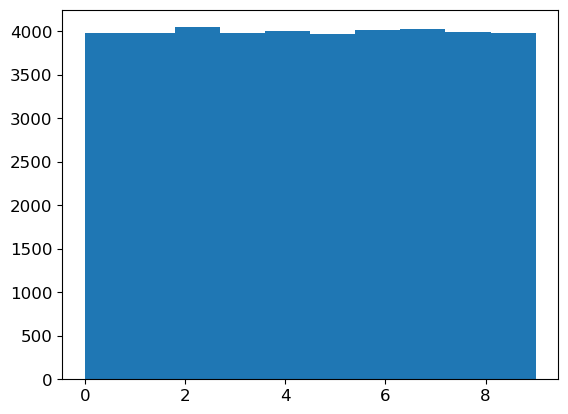

In [4]:
plt.hist(y_train)
plt.show()

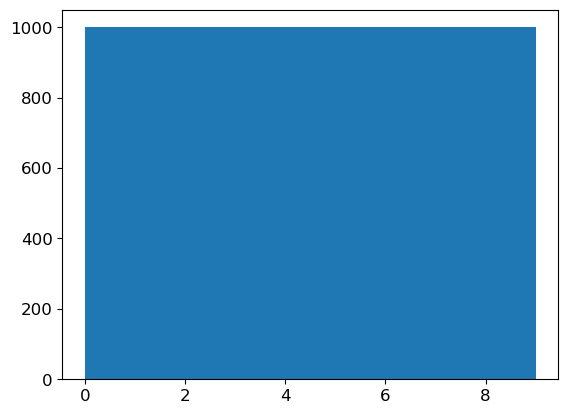

In [5]:
plt.hist(y_test)
plt.show()

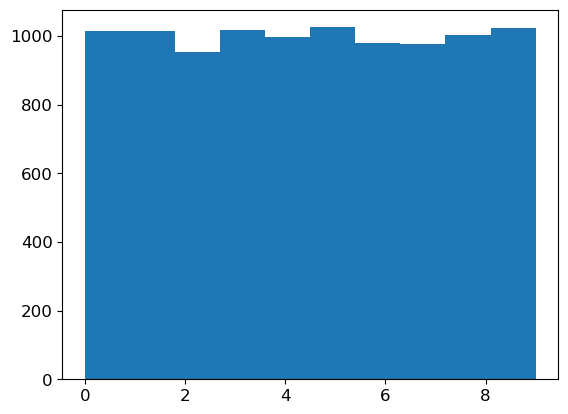

In [6]:
plt.hist(y_valid)
plt.show()

# AB. 

We do parts A and B together. 

## AB.1. Finding an appropriate learning rate.

In [33]:
np.logspace(
    start = -6,
    stop = -2,
    num = 10,
    endpoint = True,
    base= 10
)

array([1.00000000e-06, 2.78255940e-06, 7.74263683e-06, 2.15443469e-05,
       5.99484250e-05, 1.66810054e-04, 4.64158883e-04, 1.29154967e-03,
       3.59381366e-03, 1.00000000e-02])

In [34]:
histories_lr = {}

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

learning_rate_list = np.logspace(
    start = -6,
    stop = -2,
    num = 10,
    endpoint = True,
    base= 10
)

counter = 0

for lr in learning_rate_list:
    print(f" lr is {lr}")
    # copy the base model
    lr_finder_A = keras.models.Sequential(
        [
            # 0. input layer: A flatten layer with the shape 28*28. 
            keras.layers.Flatten(
                input_shape = [32, 32, 3],
                name = "flatten_input"
            ),
        ]
    )
    # Hidden layers
    n_hidden_A = 20
    for l in range(n_hidden_A):
        lr_finder_A.add(
            keras.layers.Dense(
                units = 100,
                activation = 'elu',
                kernel_initializer = keras.initializers.HeNormal( seed = 24 ), # could write "he_normal"
                name = "hidden_layer_"+str(l+1)
            )
        )
    # We use 'softmax' activation function, to get probabilities. 
    lr_finder_A.add(
        keras.layers.Dense(
            units = 10,
            activation = 'softmax',
            #kernel_initializer = keras.initializers.HeNormal( seed = 24 ), # could write "he_normal"
            name = 'output' 
        )
    )
        
    # Compile the model 
    lr_finder_A.compile(
        # we could write loss = 'sparse_categorical_crossentropy'
        loss = keras.losses.SparseCategoricalCrossentropy(), 
        #
        # we could use Nadam
        optimizer = keras.optimizers.Nadam(
            learning_rate = float(lr),
            beta_1 = 0.9,
            beta_2 = 0.999,
        ),
        #
        metrics = [keras.metrics.SparseCategoricalAccuracy()]
    )
    # fit
    lr_finder_A.fit(
        x_train,
        y_train,
        epochs = 10,
        validation_data = (x_valid, y_valid)
    )

    histories_lr[str(counter)] = { 
        'lr' : lr,
        'history' : lr_finder_A.history.history
    }
    counter +=1 

 lr is 1e-06
Epoch 1/10
1250/1250 [==============================] - 27s 17ms/step - loss: 2.6411 - sparse_categorical_accuracy: 0.1324 - val_loss: 2.3487 - val_sparse_categorical_accuracy: 0.1638
Epoch 2/10
1250/1250 [==============================] - 20s 16ms/step - loss: 2.2583 - sparse_categorical_accuracy: 0.1900 - val_loss: 2.2039 - val_sparse_categorical_accuracy: 0.2073
Epoch 3/10
1250/1250 [==============================] - 20s 16ms/step - loss: 2.1519 - sparse_categorical_accuracy: 0.2219 - val_loss: 2.1264 - val_sparse_categorical_accuracy: 0.2294
Epoch 4/10
1250/1250 [==============================] - 18s 15ms/step - loss: 2.0900 - sparse_categorical_accuracy: 0.2415 - val_loss: 2.0766 - val_sparse_categorical_accuracy: 0.2442
Epoch 5/10
1250/1250 [==============================] - 18s 15ms/step - loss: 2.0445 - sparse_categorical_accuracy: 0.2575 - val_loss: 2.0364 - val_sparse_categorical_accuracy: 0.2609
Epoch 6/10
1250/1250 [==============================] - 20s 16ms/st

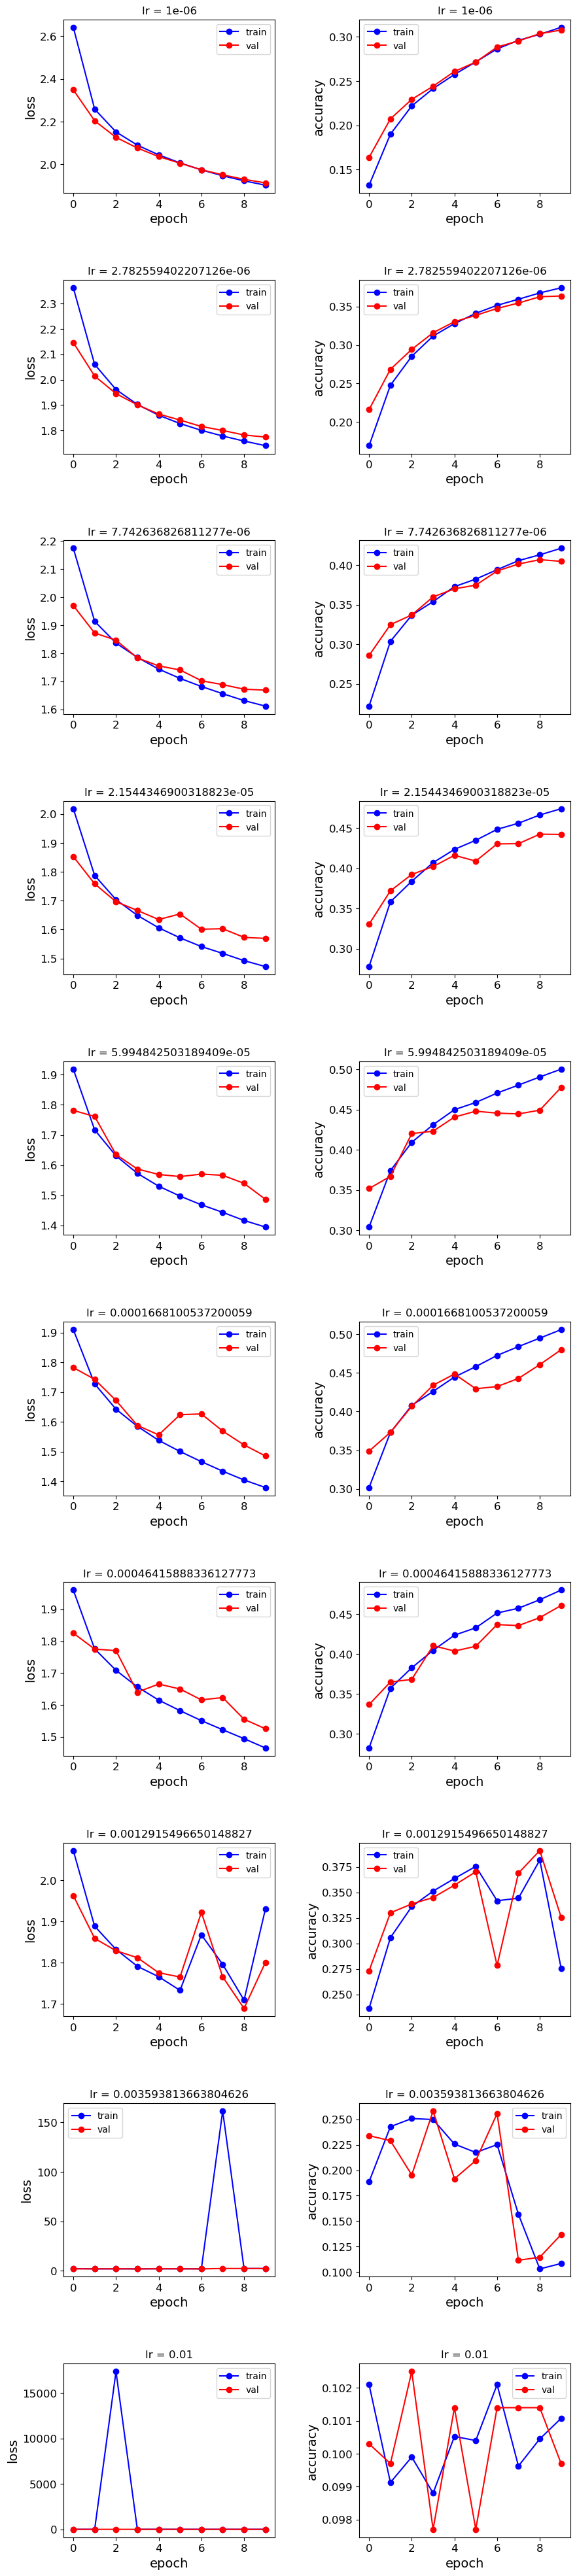

In [35]:
n_rows = counter
n_cols = 2
plt.figure(figsize=(n_cols * 5, n_rows * 5))
for row in range(n_rows):
    index = n_cols * row 
    plt.subplot(n_rows, n_cols, index + 1)
    plt.plot(histories_lr[str(row)]['history']['loss'], 'bo-', label = 'train')
    plt.plot(histories_lr[str(row)]['history']['val_loss'], 'ro-', label = 'val')
    plt.legend()
    plt.title(f"lr = {histories_lr[str(row)]['lr']}")
    plt.ylabel('loss')
    plt.xlabel('epoch')

    plt.subplot(n_rows, n_cols, index + 2)
    plt.plot(histories_lr[str(row)]['history']['sparse_categorical_accuracy'], 'bo-', label = 'train')
    plt.plot(histories_lr[str(row)]['history']['val_sparse_categorical_accuracy'], 'ro-',  label = 'val')
    plt.legend()
    plt.title(f"lr = {histories_lr[str(row)]['lr']}")
    plt.ylabel('accuracy')
    plt.xlabel('epoch')

plt.subplots_adjust(wspace=0.4, hspace=0.5)
plt.show()

Looks like diverging at around `0.01` and half of it is `0.005` at which we also see some fluctuations as well. \
So we can half that and go with `0.002`. 

## AB.2. Trainging the mode

### AB.2.1. `lr = 4e-4`

In [36]:
model_AB_1 = keras.models.Sequential(
    [
         # 0. input layer: A flatten layer with the shape 28*28. 
        keras.layers.Flatten(
            input_shape = [32, 32, 3],
            name = "flatten_input"
        ),
    ]
)
# Hidden layers
n_hidden_A = 20
for l in range(n_hidden_A):
    model_AB_1.add(
        keras.layers.Dense(
            units = 100,
            activation = 'elu',
            kernel_initializer = keras.initializers.HeNormal( seed = 24 ), # could write "he_normal"
            name = "hidden_layer_"+str(l+1)
        )
    )
# We use 'softmax' activation function, to get probabilities. 
model_AB_1.add(
    keras.layers.Dense(
        units = 10,
        activation = 'softmax',
        name = 'output' 
    )
)
# Compile 
model_AB_1.compile(
    # we could write loss = 'sparse_categorical_crossentropy'
    loss = keras.losses.SparseCategoricalCrossentropy(), 
    #
    # we use Nadam optimizer. 
    optimizer = keras.optimizers.Nadam(
            learning_rate = float(4e-4),
            beta_1 = 0.9,
            beta_2 = 0.999,
    ),
    #
    #
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)
# Fit 
model_AB_1.fit(
    x_train,
    y_train,
    epochs = 100,
    validation_data = (x_valid, y_valid),
    callbacks = [
        keras.callbacks.EarlyStopping(
            patience = 20,
            restore_best_weights = True
        )
    ]
)

Epoch 1/100
1250/1250 [==============================] - 34s 22ms/step - loss: 1.9588 - sparse_categorical_accuracy: 0.2831 - val_loss: 1.8460 - val_sparse_categorical_accuracy: 0.3273
Epoch 2/100
1250/1250 [==============================] - 25s 20ms/step - loss: 1.7698 - sparse_categorical_accuracy: 0.3528 - val_loss: 1.7388 - val_sparse_categorical_accuracy: 0.3738
Epoch 3/100
1250/1250 [==============================] - 27s 22ms/step - loss: 1.6974 - sparse_categorical_accuracy: 0.3851 - val_loss: 1.7142 - val_sparse_categorical_accuracy: 0.3967
Epoch 4/100
1250/1250 [==============================] - 27s 22ms/step - loss: 1.6463 - sparse_categorical_accuracy: 0.4060 - val_loss: 1.6455 - val_sparse_categorical_accuracy: 0.4119
Epoch 5/100
1250/1250 [==============================] - 28s 22ms/step - loss: 1.5980 - sparse_categorical_accuracy: 0.4263 - val_loss: 1.6226 - val_sparse_categorical_accuracy: 0.4174
Epoch 6/100
1250/1250 [==============================] - 27s 22ms/step - lo

Text(0.5, 0, 'epoch')

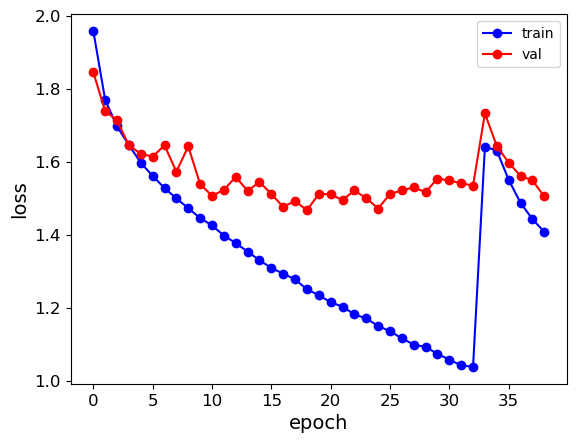

In [37]:
plt.plot(model_AB_1.history.history['loss'], 'bo-', label = 'train')
plt.plot(model_AB_1.history.history['val_loss'], 'ro-', label = 'val')
plt.legend()
#plt.title(f"lr = {histories_lr[str(row)]['lr']}")
plt.ylabel('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

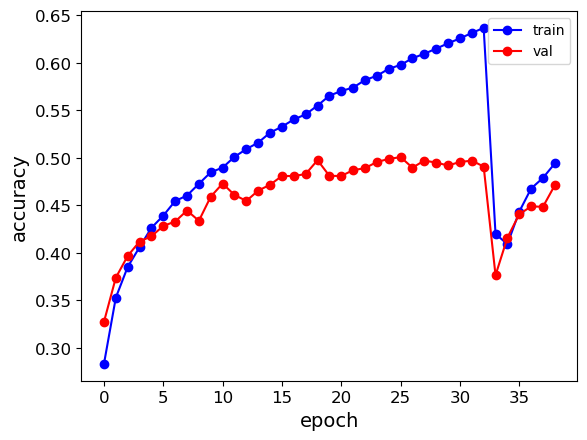

In [43]:
plt.plot(model_AB_1.history.history['sparse_categorical_accuracy'], 'bo-', label = 'train')
plt.plot(model_AB_1.history.history['val_sparse_categorical_accuracy'], 'ro-', label = 'val')
plt.legend()
#plt.title(f"lr = {histories_lr[str(row)]['lr']}")
plt.ylabel('accuracy')
plt.xlabel('epoch')

### AB.2.2. `lr = 1e-4`

In [39]:
model_AB_2 = keras.models.Sequential(
    [
         # 0. input layer: A flatten layer with the shape 28*28. 
        keras.layers.Flatten(
            input_shape = [32, 32, 3],
            name = "flatten_input"
        ),
    ]
)
# Hidden layers
n_hidden_A = 20
for l in range(n_hidden_A):
    model_AB_2.add(
        keras.layers.Dense(
            units = 100,
            activation = 'elu',
            kernel_initializer = keras.initializers.HeNormal( seed = 24 ), # could write "he_normal"
            name = "hidden_layer_"+str(l+1)
        )
    )
# We use 'softmax' activation function, to get probabilities. 
model_AB_2.add(
    keras.layers.Dense(
        units = 10,
        activation = 'softmax',
        name = 'output' 
    )
)
# Compile 
model_AB_2.compile(
    # we could write loss = 'sparse_categorical_crossentropy'
    loss = keras.losses.SparseCategoricalCrossentropy(), 
    #
    # we use Nadam optimizer. 
    optimizer = keras.optimizers.Nadam(
            learning_rate = float(1e-4),
            beta_1 = 0.9,
            beta_2 = 0.999,
    ),
    #
    #
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)
# Fit 
model_AB_2.fit(
    x_train,
    y_train,
    epochs = 100,
    validation_data = (x_valid, y_valid),
    callbacks = [
        keras.callbacks.EarlyStopping(
            patience = 20,
            restore_best_weights = True
        )
    ]
)

Epoch 1/100
1250/1250 [==============================] - 37s 24ms/step - loss: 1.8955 - sparse_categorical_accuracy: 0.3119 - val_loss: 1.7673 - val_sparse_categorical_accuracy: 0.3595
Epoch 2/100
1250/1250 [==============================] - 28s 23ms/step - loss: 1.7075 - sparse_categorical_accuracy: 0.3844 - val_loss: 1.6850 - val_sparse_categorical_accuracy: 0.3945
Epoch 3/100
1250/1250 [==============================] - 28s 22ms/step - loss: 1.6227 - sparse_categorical_accuracy: 0.4157 - val_loss: 1.6401 - val_sparse_categorical_accuracy: 0.4206
Epoch 4/100
1250/1250 [==============================] - 28s 23ms/step - loss: 1.5639 - sparse_categorical_accuracy: 0.4366 - val_loss: 1.5863 - val_sparse_categorical_accuracy: 0.4312
Epoch 5/100
1250/1250 [==============================] - 29s 23ms/step - loss: 1.5205 - sparse_categorical_accuracy: 0.4520 - val_loss: 1.5628 - val_sparse_categorical_accuracy: 0.4490
Epoch 6/100
1250/1250 [==============================] - 30s 24ms/step - lo

Text(0.5, 0, 'epoch')

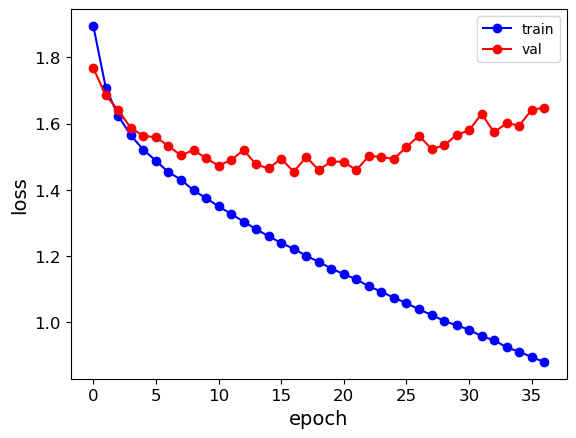

In [40]:
plt.plot(model_AB_2.history.history['loss'], 'bo-', label = 'train')
plt.plot(model_AB_2.history.history['val_loss'], 'ro-', label = 'val')
plt.legend()
#plt.title(f"lr = {histories_lr[str(row)]['lr']}")
plt.ylabel('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

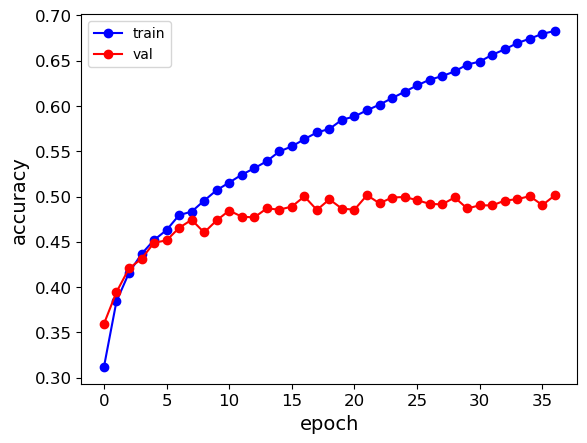

In [42]:
plt.plot(model_AB_2.history.history['sparse_categorical_accuracy'], 'bo-', label = 'train')
plt.plot(model_AB_2.history.history['val_sparse_categorical_accuracy'], 'ro-', label = 'val')
plt.legend()
#plt.title(f"lr = {histories_lr[str(row)]['lr']}")
plt.ylabel('accuracy')
plt.xlabel('epoch')

### AB.2.3. `lr = 4e-5`

In [44]:
model_AB_3 = keras.models.Sequential(
    [
         # 0. input layer: A flatten layer with the shape 28*28. 
        keras.layers.Flatten(
            input_shape = [32, 32, 3],
            name = "flatten_input"
        ),
    ]
)
# Hidden layers
n_hidden_A = 20
for l in range(n_hidden_A):
    model_AB_3.add(
        keras.layers.Dense(
            units = 100,
            activation = 'elu',
            kernel_initializer = keras.initializers.HeNormal( seed = 24 ), # could write "he_normal"
            name = "hidden_layer_"+str(l+1)
        )
    )
# We use 'softmax' activation function, to get probabilities. 
model_AB_3.add(
    keras.layers.Dense(
        units = 10,
        activation = 'softmax',
        name = 'output' 
    )
)
# Compile 
model_AB_3.compile(
    # we could write loss = 'sparse_categorical_crossentropy'
    loss = keras.losses.SparseCategoricalCrossentropy(), 
    #
    # we use Nadam optimizer. 
    optimizer = keras.optimizers.Nadam(
            learning_rate = float(4e-5),
            beta_1 = 0.9,
            beta_2 = 0.999,
    ),
    #
    #
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)
# Fit 
model_AB_3.fit(
    x_train,
    y_train,
    epochs = 100,
    validation_data = (x_valid, y_valid),
    callbacks = [
        keras.callbacks.EarlyStopping(
            patience = 10,
            restore_best_weights = True
        )
    ]
)

Epoch 1/100
1250/1250 [==============================] - 27s 19ms/step - loss: 1.9550 - sparse_categorical_accuracy: 0.2947 - val_loss: 1.7806 - val_sparse_categorical_accuracy: 0.3583
Epoch 2/100
1250/1250 [==============================] - 23s 19ms/step - loss: 1.7286 - sparse_categorical_accuracy: 0.3755 - val_loss: 1.7224 - val_sparse_categorical_accuracy: 0.3795
Epoch 3/100
1250/1250 [==============================] - 23s 18ms/step - loss: 1.6480 - sparse_categorical_accuracy: 0.4048 - val_loss: 1.6587 - val_sparse_categorical_accuracy: 0.4086
Epoch 4/100
1250/1250 [==============================] - 24s 19ms/step - loss: 1.5926 - sparse_categorical_accuracy: 0.4277 - val_loss: 1.6012 - val_sparse_categorical_accuracy: 0.4272
Epoch 5/100
1250/1250 [==============================] - 24s 19ms/step - loss: 1.5486 - sparse_categorical_accuracy: 0.4433 - val_loss: 1.6005 - val_sparse_categorical_accuracy: 0.4315
Epoch 6/100
1250/1250 [==============================] - 24s 19ms/step - lo

Text(0.5, 0, 'epoch')

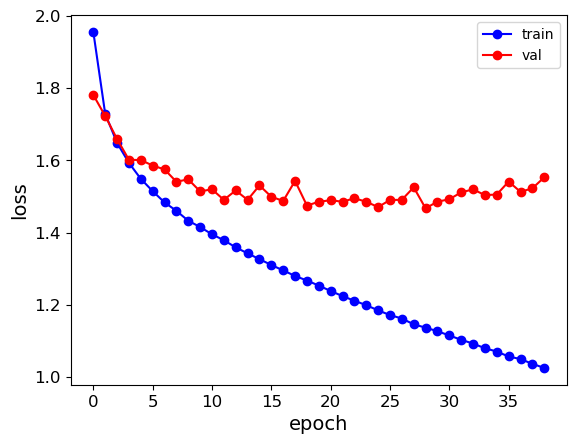

In [45]:
plt.plot(model_AB_3.history.history['loss'], 'bo-', label = 'train')
plt.plot(model_AB_3.history.history['val_loss'], 'ro-', label = 'val')
plt.legend()
#plt.title(f"lr = {histories_lr[str(row)]['lr']}")
plt.ylabel('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

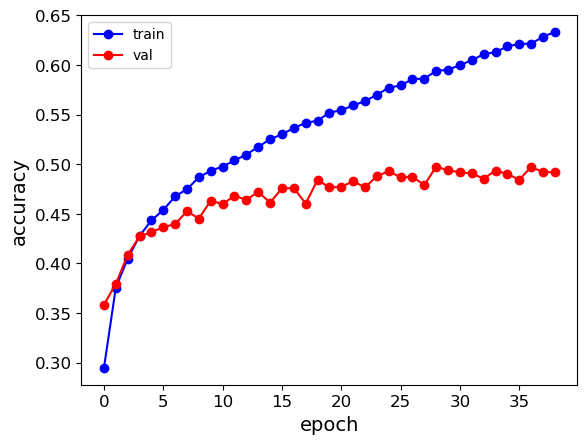

In [46]:
plt.plot(model_AB_3.history.history['sparse_categorical_accuracy'], 'bo-', label = 'train')
plt.plot(model_AB_3.history.history['val_sparse_categorical_accuracy'], 'ro-', label = 'val')
plt.legend()
#plt.title(f"lr = {histories_lr[str(row)]['lr']}")
plt.ylabel('accuracy')
plt.xlabel('epoch')

### AB.2.4. `lr = 1e-5`

In [47]:
model_AB_4 = keras.models.Sequential(
    [
         # 0. input layer: A flatten layer with the shape 28*28. 
        keras.layers.Flatten(
            input_shape = [32, 32, 3],
            name = "flatten_input"
        ),
    ]
)
# Hidden layers
n_hidden_A = 20
for l in range(n_hidden_A):
    model_AB_4.add(
        keras.layers.Dense(
            units = 100,
            activation = 'elu',
            kernel_initializer = keras.initializers.HeNormal( seed = 24 ), # could write "he_normal"
            name = "hidden_layer_"+str(l+1)
        )
    )
# We use 'softmax' activation function, to get probabilities. 
model_AB_4.add(
    keras.layers.Dense(
        units = 10,
        activation = 'softmax',
        name = 'output' 
    )
)
# Compile 
model_AB_4.compile(
    # we could write loss = 'sparse_categorical_crossentropy'
    loss = keras.losses.SparseCategoricalCrossentropy(), 
    #
    # we use Nadam optimizer. 
    optimizer = keras.optimizers.Nadam(
            learning_rate = float(1e-5),
            beta_1 = 0.9,
            beta_2 = 0.999,
    ),
    #
    #
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)
# Fit 
model_AB_4.fit(
    x_train,
    y_train,
    epochs = 100,
    validation_data = (x_valid, y_valid),
    callbacks = [
        keras.callbacks.EarlyStopping(
            patience = 10,
            restore_best_weights = True
        )
    ]
)

Epoch 1/100
1250/1250 [==============================] - 26s 19ms/step - loss: 2.1160 - sparse_categorical_accuracy: 0.2422 - val_loss: 1.9323 - val_sparse_categorical_accuracy: 0.2995
Epoch 2/100
1250/1250 [==============================] - 22s 17ms/step - loss: 1.8642 - sparse_categorical_accuracy: 0.3246 - val_loss: 1.8247 - val_sparse_categorical_accuracy: 0.3448
Epoch 3/100
1250/1250 [==============================] - 23s 18ms/step - loss: 1.7815 - sparse_categorical_accuracy: 0.3548 - val_loss: 1.7788 - val_sparse_categorical_accuracy: 0.3639
Epoch 4/100
1250/1250 [==============================] - 23s 18ms/step - loss: 1.7295 - sparse_categorical_accuracy: 0.3762 - val_loss: 1.7365 - val_sparse_categorical_accuracy: 0.3824
Epoch 5/100
1250/1250 [==============================] - 23s 18ms/step - loss: 1.6904 - sparse_categorical_accuracy: 0.3922 - val_loss: 1.7039 - val_sparse_categorical_accuracy: 0.3933
Epoch 6/100
1250/1250 [==============================] - 23s 19ms/step - lo

Text(0.5, 0, 'epoch')

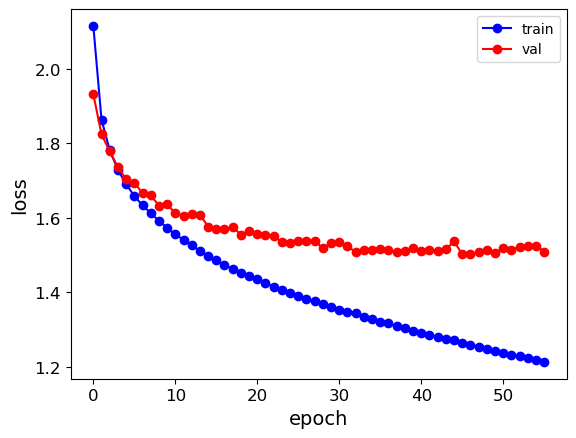

In [48]:
plt.plot(model_AB_4.history.history['loss'], 'bo-', label = 'train')
plt.plot(model_AB_4.history.history['val_loss'], 'ro-', label = 'val')
plt.legend()
#plt.title(f"lr = {histories_lr[str(row)]['lr']}")
plt.ylabel('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

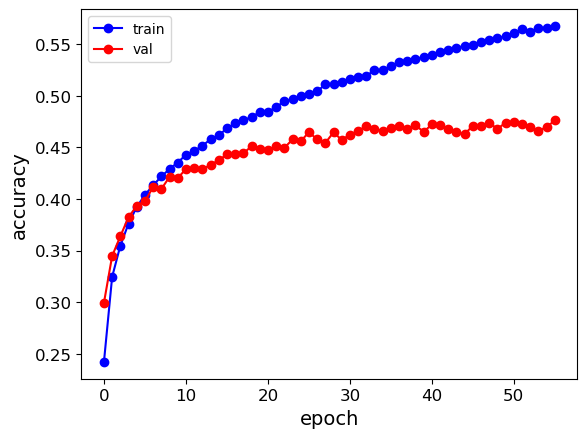

In [49]:
plt.plot(model_AB_4.history.history['sparse_categorical_accuracy'], 'bo-', label = 'train')
plt.plot(model_AB_4.history.history['val_sparse_categorical_accuracy'], 'ro-', label = 'val')
plt.legend()
#plt.title(f"lr = {histories_lr[str(row)]['lr']}")
plt.ylabel('accuracy')
plt.xlabel('epoch')

OK, from 2-3 they are all sort of the same and reach the same result. 
- `lr=1e-4` is a bit faster though.
- `lr=1e-5` is smoother in loss. 

so sth between these two would be good for this architecture. 

# C.  Adding Batch Normalization

BN after activation, like page 342. 

## C.1. Finding an appropriate learning rate. 

In [11]:
np.logspace(
    start = -3,
    stop = -1.25,
    num = 5,
    endpoint = True,
    base= 10
)

array([0.001     , 0.00273842, 0.00749894, 0.02053525, 0.05623413])

In [15]:
histories_lr_C = {}

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

learning_rate_list = [0.001, 0.005, 0.01]

counter = 0

for lr in learning_rate_list:
    print(f" lr is {lr}")
    # copy the base model
    lr_finder_C = keras.models.Sequential(
        [
            # 0. input layer: A flatten layer with the shape 28*28. 
            keras.layers.Flatten(
                input_shape = [32, 32, 3],
                name = "flatten_input"
            ),
            keras.layers.BatchNormalization()
        ]
    )
    # Hidden layers
    n_hidden_A = 20
    for l in range(n_hidden_A):
        lr_finder_C.add(
            keras.layers.Dense(
                units = 100,
                activation = 'elu',
                kernel_initializer = keras.initializers.HeNormal( seed = 24 ), # could write "he_normal"
                name = "hidden_layer_"+str(l+1)
            )
        )
        lr_finder_C.add(
            keras.layers.BatchNormalization()
        )

    # We use 'softmax' activation function, to get probabilities. 
    lr_finder_C.add(
        keras.layers.Dense(
            units = 10,
            activation = 'softmax',
            #kernel_initializer = keras.initializers.HeNormal( seed = 24 ), # could write "he_normal"
            name = 'output' 
        )
    )

    #lr_finder_C.summary()
        
    # Compile the model 
    lr_finder_C.compile(
        # we could write loss = 'sparse_categorical_crossentropy'
        loss = keras.losses.SparseCategoricalCrossentropy(), 
        #
        # we could use Nadam
        optimizer = keras.optimizers.Nadam(
            learning_rate = float(lr),
            beta_1 = 0.9,
            beta_2 = 0.999,
        ),
        #
        metrics = [keras.metrics.SparseCategoricalAccuracy()]
    )
    # fit
    lr_finder_C.fit(
        x_train,
        y_train,
        epochs = 10,
        validation_data = (x_valid, y_valid)
    )

    histories_lr_C[str(counter)] = { 
        'lr' : lr,
        'history' : lr_finder_C.history.history
    }
    counter +=1 

 lr is 0.001
Epoch 1/10
1250/1250 [==============================] - 27s 15ms/step - loss: 1.9219 - sparse_categorical_accuracy: 0.3094 - val_loss: 1.7334 - val_sparse_categorical_accuracy: 0.3741
Epoch 2/10
1250/1250 [==============================] - 19s 15ms/step - loss: 1.7350 - sparse_categorical_accuracy: 0.3809 - val_loss: 1.6484 - val_sparse_categorical_accuracy: 0.4152
Epoch 3/10
1250/1250 [==============================] - 18s 15ms/step - loss: 1.6638 - sparse_categorical_accuracy: 0.4068 - val_loss: 1.5938 - val_sparse_categorical_accuracy: 0.4373
Epoch 4/10
1250/1250 [==============================] - 18s 15ms/step - loss: 1.6162 - sparse_categorical_accuracy: 0.4268 - val_loss: 1.5459 - val_sparse_categorical_accuracy: 0.4471
Epoch 5/10
1250/1250 [==============================] - 18s 14ms/step - loss: 1.5707 - sparse_categorical_accuracy: 0.4423 - val_loss: 1.5337 - val_sparse_categorical_accuracy: 0.4470
Epoch 6/10
1250/1250 [==============================] - 18s 14ms/st

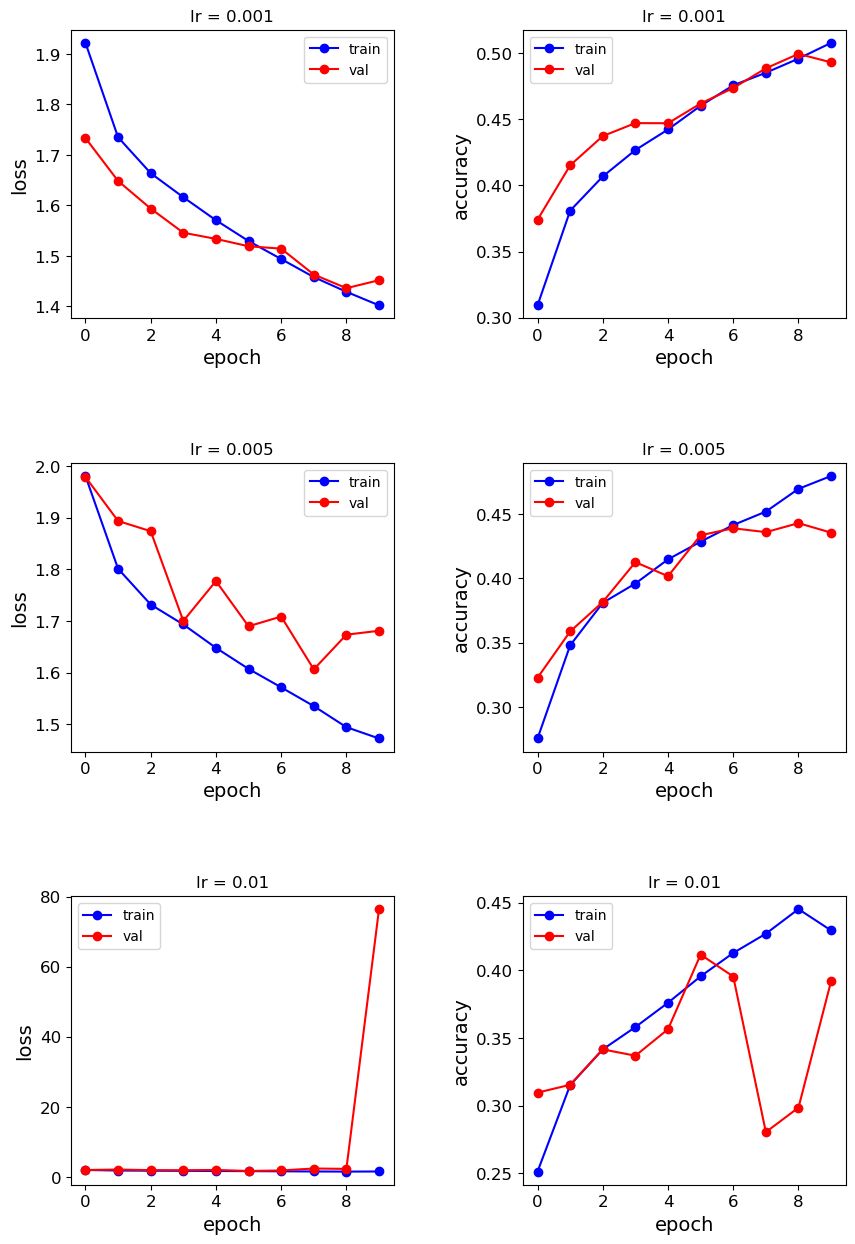

In [17]:
n_rows = counter
n_cols = 2
plt.figure(figsize=(n_cols * 5, n_rows * 5))
for row in range(n_rows):
    index = n_cols * row 
    plt.subplot(n_rows, n_cols, index + 1)
    plt.plot(histories_lr_C[str(row)]['history']['loss'], 'bo-', label = 'train')
    plt.plot(histories_lr_C[str(row)]['history']['val_loss'], 'ro-', label = 'val')
    plt.legend()
    plt.title(f"lr = {histories_lr_C[str(row)]['lr']}")
    plt.ylabel('loss')
    plt.xlabel('epoch')

    plt.subplot(n_rows, n_cols, index + 2)
    plt.plot(histories_lr_C[str(row)]['history']['sparse_categorical_accuracy'], 'bo-', label = 'train')
    plt.plot(histories_lr_C[str(row)]['history']['val_sparse_categorical_accuracy'], 'ro-',  label = 'val')
    plt.legend()
    plt.title(f"lr = {histories_lr_C[str(row)]['lr']}")
    plt.ylabel('accuracy')
    plt.xlabel('epoch')

plt.subplots_adjust(wspace=0.4, hspace=0.5)
plt.show()

## C.2. Train the model 

### C.2.1. `lr = 1e-3`

In [23]:
model_C_1 = keras.models.Sequential(
    [
        # 0. input layer: A flatten layer with the shape 28*28. 
        keras.layers.Flatten(
            input_shape = [32, 32, 3],
            name = "flatten_input"
        ),
        keras.layers.BatchNormalization(name = "BN_input")
    ]
)
# Hidden layers
n_hidden_A = 20
for l in range(n_hidden_A):
    model_C_1.add(
        keras.layers.Dense(
            units = 100,
            activation = 'elu',
            kernel_initializer = keras.initializers.HeNormal( seed = 24 ), # could write "he_normal"
            name = "hidden_layer_"+str(l+1)
        )
    )
    model_C_1.add(
        keras.layers.BatchNormalization(name = "BN_"+str(l+1))
    )

# We use 'softmax' activation function, to get probabilities. 
model_C_1.add(
    keras.layers.Dense(
        units = 10,
        activation = 'softmax',
        #kernel_initializer = keras.initializers.HeNormal( seed = 24 ), # could write "he_normal"
        name = 'output' 
    )
)

#model_C_1.summary()
    
# Compile the model 
model_C_1.compile(
    # we could write loss = 'sparse_categorical_crossentropy'
    loss = keras.losses.SparseCategoricalCrossentropy(), 
    #
    # we could use Nadam
    optimizer = keras.optimizers.Nadam(
        learning_rate = float(1e-3),
        beta_1 = 0.9,
        beta_2 = 0.999,
    ),
    #
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)
# fit
model_C_1.fit(
    x_train,
    y_train,
    epochs = 100,
    validation_data = (x_valid, y_valid),
    callbacks = [
        keras.callbacks.EarlyStopping(
            patience = 10,
            restore_best_weights = True
        )
    ]
)

Epoch 1/100
1250/1250 [==============================] - 23s 12ms/step - loss: 1.9256 - sparse_categorical_accuracy: 0.3075 - val_loss: 1.7470 - val_sparse_categorical_accuracy: 0.3700
Epoch 2/100
1250/1250 [==============================] - 14s 11ms/step - loss: 1.7372 - sparse_categorical_accuracy: 0.3784 - val_loss: 1.6587 - val_sparse_categorical_accuracy: 0.4130
Epoch 3/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.6648 - sparse_categorical_accuracy: 0.4062 - val_loss: 1.5619 - val_sparse_categorical_accuracy: 0.4478
Epoch 4/100
1250/1250 [==============================] - 16s 12ms/step - loss: 1.6148 - sparse_categorical_accuracy: 0.4293 - val_loss: 1.5492 - val_sparse_categorical_accuracy: 0.4560
Epoch 5/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.5674 - sparse_categorical_accuracy: 0.4433 - val_loss: 1.5228 - val_sparse_categorical_accuracy: 0.4547
Epoch 6/100
1250/1250 [==============================] - 17s 13ms/step - lo

Text(0.5, 0, 'epoch')

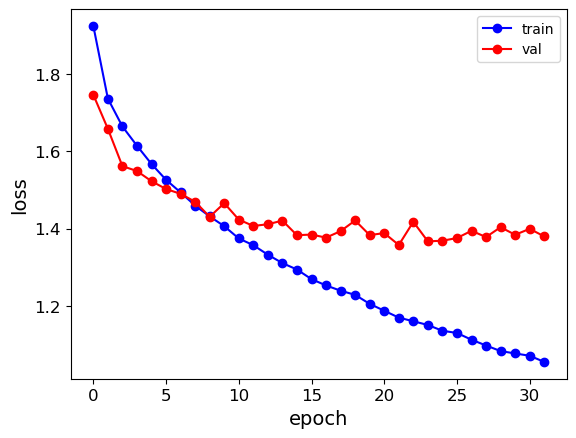

In [24]:
plt.plot(model_C_1.history.history['loss'], 'bo-', label = 'train')
plt.plot(model_C_1.history.history['val_loss'], 'ro-', label = 'val')
plt.legend()
#plt.title(f"lr = {histories_lr[str(row)]['lr']}")
plt.ylabel('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

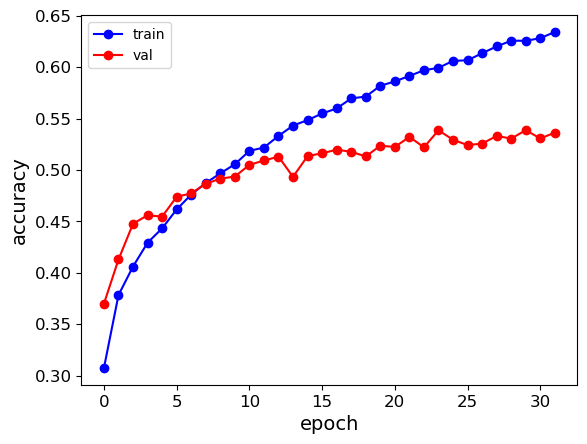

In [25]:
plt.plot(model_C_1.history.history['sparse_categorical_accuracy'], 'bo-', label = 'train')
plt.plot(model_C_1.history.history['val_sparse_categorical_accuracy'], 'ro-', label = 'val')
plt.legend()
#plt.title(f"lr = {histories_lr[str(row)]['lr']}")
plt.ylabel('accuracy')
plt.xlabel('epoch')

### C.2.2. `lr = 5e-3`

In [26]:
model_C_2 = keras.models.Sequential(
    [
        # 0. input layer: A flatten layer with the shape 28*28. 
        keras.layers.Flatten(
            input_shape = [32, 32, 3],
            name = "flatten_input"
        ),
        keras.layers.BatchNormalization(name = "BN_input")
    ]
)
# Hidden layers
n_hidden_A = 20
for l in range(n_hidden_A):
    model_C_2.add(
        keras.layers.Dense(
            units = 100,
            activation = 'elu',
            kernel_initializer = keras.initializers.HeNormal( seed = 24 ), # could write "he_normal"
            name = "hidden_layer_"+str(l+1)
        )
    )
    model_C_2.add(
        keras.layers.BatchNormalization(name = "BN_"+str(l+1))
    )

# We use 'softmax' activation function, to get probabilities. 
model_C_2.add(
    keras.layers.Dense(
        units = 10,
        activation = 'softmax',
        #kernel_initializer = keras.initializers.HeNormal( seed = 24 ), # could write "he_normal"
        name = 'output' 
    )
)

#model_C_2.summary()
    
# Compile the model 
model_C_2.compile(
    # we could write loss = 'sparse_categorical_crossentropy'
    loss = keras.losses.SparseCategoricalCrossentropy(), 
    #
    # we could use Nadam
    optimizer = keras.optimizers.Nadam(
        learning_rate = float(1e-3),
        beta_1 = 0.9,
        beta_2 = 0.999,
    ),
    #
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)
# fit
model_C_2.fit(
    x_train,
    y_train,
    epochs = 100,
    validation_data = (x_valid, y_valid),
    callbacks = [
        keras.callbacks.EarlyStopping(
            patience = 10,
            restore_best_weights = True
        )
    ]
)

Epoch 1/100
1250/1250 [==============================] - 22s 11ms/step - loss: 1.9252 - sparse_categorical_accuracy: 0.3064 - val_loss: 1.7308 - val_sparse_categorical_accuracy: 0.3797
Epoch 2/100
1250/1250 [==============================] - 14s 11ms/step - loss: 1.7387 - sparse_categorical_accuracy: 0.3799 - val_loss: 1.6597 - val_sparse_categorical_accuracy: 0.4062
Epoch 3/100
1250/1250 [==============================] - 14s 11ms/step - loss: 1.6632 - sparse_categorical_accuracy: 0.4078 - val_loss: 1.5899 - val_sparse_categorical_accuracy: 0.4328
Epoch 4/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.6217 - sparse_categorical_accuracy: 0.4261 - val_loss: 1.5244 - val_sparse_categorical_accuracy: 0.4535
Epoch 5/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.5700 - sparse_categorical_accuracy: 0.4442 - val_loss: 1.5206 - val_sparse_categorical_accuracy: 0.4605
Epoch 6/100
1250/1250 [==============================] - 15s 12ms/step - lo

Text(0.5, 0, 'epoch')

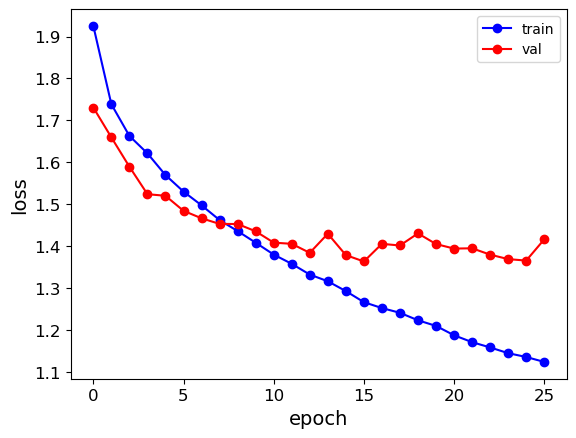

In [27]:
plt.plot(model_C_2.history.history['loss'], 'bo-', label = 'train')
plt.plot(model_C_2.history.history['val_loss'], 'ro-', label = 'val')
plt.legend()
#plt.title(f"lr = {histories_lr[str(row)]['lr']}")
plt.ylabel('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

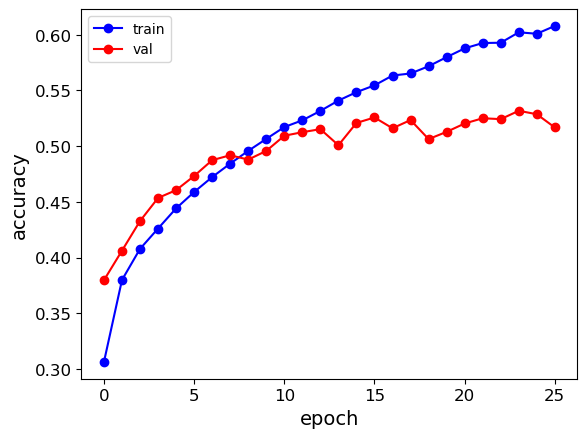

In [28]:
plt.plot(model_C_2.history.history['sparse_categorical_accuracy'], 'bo-', label = 'train')
plt.plot(model_C_2.history.history['val_sparse_categorical_accuracy'], 'ro-', label = 'val')
plt.legend()
#plt.title(f"lr = {histories_lr[str(row)]['lr']}")
plt.ylabel('accuracy')
plt.xlabel('epoch')

# D.  Using SELU activation function

## D.1. Finding an appropriate learning rate. 

In [23]:
histories_lr_D = {}

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

learning_rate_list = [1e-4,
                      5e-4, 
                      1e-3, 
                      3e-3
]
# np.logspace(
#     start = -6,
#     stop = -1,
#     num = 6,
#     endpoint = True,
#     base= 10
# )

counter = 0

for lr in learning_rate_list:
    print(f" lr is {lr}")
    # copy the base model
    lr_finder_D = keras.models.Sequential(
        [
            # 0. input layer: A flatten layer with the shape 28*28. 
            keras.layers.Flatten(
                input_shape = [32, 32, 3],
                name = "flatten_input"
            )
        ]
    )
    # Hidden layers
    n_hidden_A = 20
    for l in range(n_hidden_A):
        lr_finder_D.add(
            keras.layers.Dense(
                units = 100,
                activation = 'selu',
                kernel_initializer ="lecun_normal",
                name = "hidden_layer_"+str(l+1)
            )
        )
    # We use 'softmax' activation function, to get probabilities. 
    lr_finder_D.add(
        keras.layers.Dense(
            units = 10,
            activation = 'softmax',
            name = 'output' 
        )
    )

    # Compile the model 
    lr_finder_D.compile(
        # we could write loss = 'sparse_categorical_crossentropy'
        loss = keras.losses.SparseCategoricalCrossentropy(), 
        #
        # we could use Nadam
        optimizer = keras.optimizers.Nadam(
            learning_rate = float(lr),
            beta_1 = 0.9,
            beta_2 = 0.999,
        ),
        #
        metrics = [keras.metrics.SparseCategoricalAccuracy()]
    )
    # fit
    lr_finder_D.fit(
        x_train_normalized,
        y_train,
        epochs = 5,
        validation_data = (x_valid_normalized, y_valid)
    )

    histories_lr_D[str(counter)] = { 
        'lr' : lr,
        'history' : lr_finder_D.history.history
    }
    counter +=1 

 lr is 0.0001
Epoch 1/5
1250/1250 [==============================] - 25s 15ms/step - loss: 1.8376 - sparse_categorical_accuracy: 0.3412 - val_loss: 1.7301 - val_sparse_categorical_accuracy: 0.3717
Epoch 2/5
1250/1250 [==============================] - 18s 14ms/step - loss: 1.6237 - sparse_categorical_accuracy: 0.4189 - val_loss: 1.6213 - val_sparse_categorical_accuracy: 0.4241
Epoch 3/5
1250/1250 [==============================] - 18s 14ms/step - loss: 1.5281 - sparse_categorical_accuracy: 0.4576 - val_loss: 1.5754 - val_sparse_categorical_accuracy: 0.4442
Epoch 4/5
1250/1250 [==============================] - 19s 15ms/step - loss: 1.4562 - sparse_categorical_accuracy: 0.4798 - val_loss: 1.5430 - val_sparse_categorical_accuracy: 0.4617
Epoch 5/5
1250/1250 [==============================] - 19s 15ms/step - loss: 1.3976 - sparse_categorical_accuracy: 0.5034 - val_loss: 1.5223 - val_sparse_categorical_accuracy: 0.4728
 lr is 0.0005
Epoch 1/5
1250/1250 [==============================] - 24

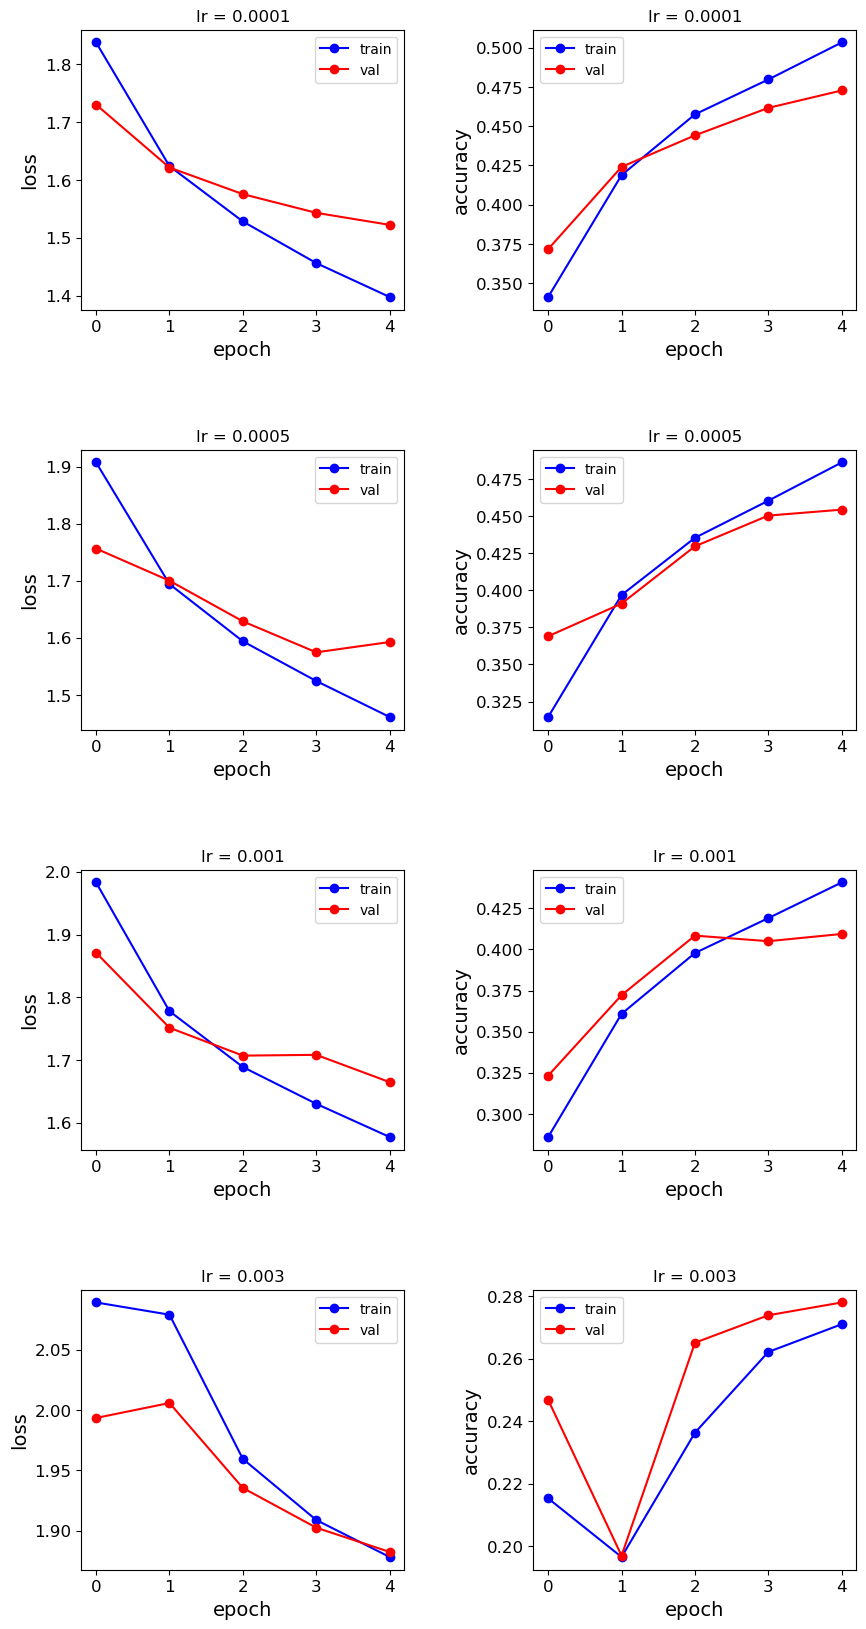

In [24]:
n_rows = counter
n_cols = 2
plt.figure(figsize=(n_cols * 5, n_rows * 5))
for row in range(n_rows):
    index = n_cols * row 
    plt.subplot(n_rows, n_cols, index + 1)
    plt.plot(histories_lr_D[str(row)]['history']['loss'], 'bo-', label = 'train')
    plt.plot(histories_lr_D[str(row)]['history']['val_loss'], 'ro-', label = 'val')
    plt.legend()
    plt.title(f"lr = {histories_lr_D[str(row)]['lr']}")
    plt.ylabel('loss')
    plt.xlabel('epoch')

    plt.subplot(n_rows, n_cols, index + 2)
    plt.plot(histories_lr_D[str(row)]['history']['sparse_categorical_accuracy'], 'bo-', label = 'train')
    plt.plot(histories_lr_D[str(row)]['history']['val_sparse_categorical_accuracy'], 'ro-',  label = 'val')
    plt.legend()
    plt.title(f"lr = {histories_lr_D[str(row)]['lr']}")
    plt.ylabel('accuracy')
    plt.xlabel('epoch')

plt.subplots_adjust(wspace=0.4, hspace=0.5)
plt.show()

## D.2 Training the model

### D.2.1. `lr =1e-4`

In [26]:
model_D_1 = keras.models.Sequential(
    [
        # 0. input layer: A flatten layer with the shape 28*28. 
        keras.layers.Flatten(
            input_shape = [32, 32, 3],
            name = "flatten_input"
        )
    ]
)
n_hidden_A = 20
for l in range(n_hidden_A):
    model_D_1.add(
        keras.layers.Dense(
            units = 100,
            activation = 'selu',
            kernel_initializer ="lecun_normal",
            name = "hidden_layer_"+str(l+1)
        )
    )
# We use 'softmax' activation function, to get probabilities. 
model_D_1.add(
    keras.layers.Dense(
        units = 10,
        activation = 'softmax',
        name = 'output' 
    )
)
# Compile the model 
model_D_1.compile(
    # we could write loss = 'sparse_categorical_crossentropy'
    loss = keras.losses.SparseCategoricalCrossentropy(), 
    #
    # we could use Nadam
    optimizer = keras.optimizers.Nadam(
        learning_rate = float(1e-4),
        beta_1 = 0.9,
        beta_2 = 0.999,
    ),
    #
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)
# fit
model_D_1.fit(
    x_train_normalized,
    y_train,
    epochs = 50,
    validation_data = (x_valid_normalized, y_valid),
    callbacks = [
        keras.callbacks.EarlyStopping(
            patience = 10,
            restore_best_weights = True
        )
    ]
    
)

Epoch 1/50
1250/1250 [==============================] - 23s 15ms/step - loss: 1.8330 - sparse_categorical_accuracy: 0.3489 - val_loss: 1.6964 - val_sparse_categorical_accuracy: 0.3947
Epoch 2/50
1250/1250 [==============================] - 18s 15ms/step - loss: 1.6178 - sparse_categorical_accuracy: 0.4228 - val_loss: 1.6115 - val_sparse_categorical_accuracy: 0.4300
Epoch 3/50
1250/1250 [==============================] - 19s 15ms/step - loss: 1.5200 - sparse_categorical_accuracy: 0.4595 - val_loss: 1.5481 - val_sparse_categorical_accuracy: 0.4522
Epoch 4/50
1250/1250 [==============================] - 19s 15ms/step - loss: 1.4510 - sparse_categorical_accuracy: 0.4818 - val_loss: 1.5438 - val_sparse_categorical_accuracy: 0.4504
Epoch 5/50
1250/1250 [==============================] - 17s 14ms/step - loss: 1.3888 - sparse_categorical_accuracy: 0.5037 - val_loss: 1.5010 - val_sparse_categorical_accuracy: 0.4669
Epoch 6/50
1250/1250 [==============================] - 16s 13ms/step - loss: 1.

Text(0.5, 0, 'epoch')

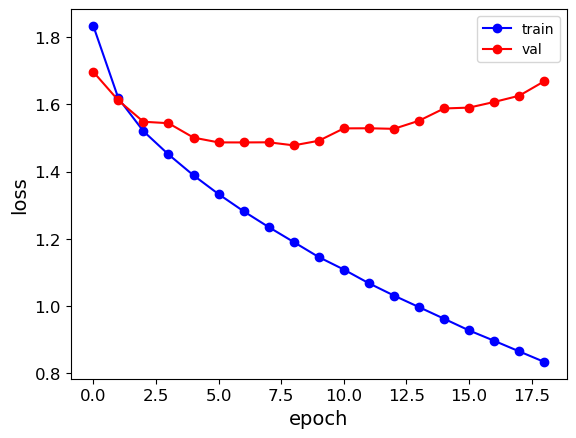

In [27]:
plt.plot(model_D_1.history.history['loss'], 'bo-', label = 'train')
plt.plot(model_D_1.history.history['val_loss'], 'ro-', label = 'val')
plt.legend()
#plt.title(f"lr = {histories_lr[str(row)]['lr']}")
plt.ylabel('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

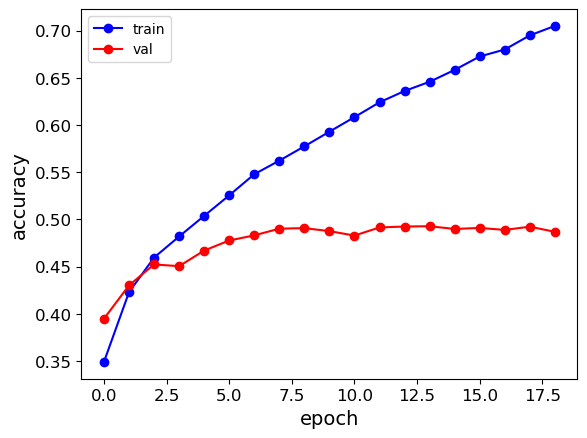

In [28]:
plt.plot(model_D_1.history.history['sparse_categorical_accuracy'], 'bo-', label = 'train')
plt.plot(model_D_1.history.history['val_sparse_categorical_accuracy'], 'ro-', label = 'val')
plt.legend()
#plt.title(f"lr = {histories_lr[str(row)]['lr']}")
plt.ylabel('accuracy')
plt.xlabel('epoch')